In [49]:
import pandas as pd
import re

### Load the rules export

In [50]:
# load your YARA-L rules JSON export here
rules_set = pd.read_json(".json")

ValueError: Expected object or value

In [51]:
tags_data = {}
rules_by_tag = {}  # this will hold information about rules and tags

rules_counter = 0
rules_with_tag_counter = 0
rules_with_mitre_meta = 0
rules_with_mitre_ids = 0



for item in rules_set['ruleJobLists']:
    rule_name = item['rule']['properties']['name']
    if  'mitre' in item['rule']['properties']['metadata']:
        rules_with_mitre_meta += 1
        tags = (item['rule']['properties']['metadata']['mitre']).replace(" ", "").upper().split(',')
        for tag in tags:
            tech_number = re.match(r".*(T\d{4}\.?\d?\d?\d?)", tag)
            if tech_number:
                if not tech_number.group(1) in rules_by_tag:
                    rules_by_tag[tech_number.group(1)] = {rule_name}  # set
                else:
                    rules_by_tag[tech_number.group(1)].add(rule_name)
    
    elif  'tags' in item['rule']['properties']['metadata']:
        rules_with_tag_counter += 1

        #remove whitespace, split by comma to an array
        tag_string = item['rule']['properties']['metadata']['tags'].replace(" ", "").lower()
        #split into list
        tags = tag_string.split(',')
        # if key .. the tag is not present, create new entry with key:1 otherwise increase the counter
        for tag in tags:

            if ('evasion') in tag:
                tag = 'attack.defense_evasion'
            elif 'defen' in tag:
                tag = 'attack.defense_evasion'
            elif 'pers' in tag:
                tag = 'attack.persistence'
            elif 'comm' in tag:
                tag = 'attack.command_and_control'
            elif 'creden' in tag:
                tag = 'attack.credential_access'            
            elif 'latera' in tag:
                tag = 'attack.lateral_movement'
            elif 'privileg' in tag:
                tag = 'attack.privilege_escalation'
            elif 'initial' in tag:
                tag = 'attack.initial_access'
            elif re.match(r".*ex.*ion",tag):
                tag = 'attack.execution'
            
            
            if not tag in tags_data:
                tags_data[tag] = 1 
            else:
                tags_data[tag] += 1
            
            tag = tag.upper()
            tech_number = re.match(r".*(T\d{4}\.?\d?\d?\d?)", tag)
            if tech_number:
                if not tech_number.group(1) in rules_by_tag:
                    rules_by_tag[tech_number.group(1)] = {rule_name}  # set
                else:
                    rules_by_tag[tech_number.group(1)].add(rule_name)
    elif 'mitre_ids' in item['rule']['properties']['metadata']:
        # rules are store like this TA0011;TA0003;T1071;T1547
        tags = (item['rule']['properties']['metadata']['mitre_ids']).upper().split(';')
        for tag in tags:
            tech_number = re.match(r".*(T\d{4}\.?\d?\d?\d?)", tag)
            if tech_number:
                if not tech_number.group(1) in rules_by_tag:
                    rules_by_tag[tech_number.group(1)] = {rule_name}  # set
                else:
                    rules_by_tag[tech_number.group(1)].add(rule_name)
        
        rules_with_mitre_ids += 1
    rules_counter += 1


### Get some basic overview of the data
How many rules we have in the set. Different authors use different meta tags for storing the MITRE data.
So far I saw this to be stored in "tag", "mitre_tag" and  "mitre_ids" tag

In [52]:
print(f"Rules found:{rules_counter}")
print(f"Rules with tag:{rules_with_tag_counter}")
print(f"Rules with mitre tag:{rules_with_mitre_meta}")
print(f"Rules with mitre_ids tag:{rules_with_mitre_ids}")

Rules found:2618
Rules with tag:2281
Rules with mitre tag:168
Rules with mitre_ids tag:137


#### What log sources are used in our rules?

In [53]:
# count by logsources
OS = {}
for item in rules_set['ruleJobLists']:
    #rules_set['ruleJobLists'][item]['rule']['properties']['metadata']
    if  'logsource' in item['rule']['properties']['metadata']:
        #print(item['rule']['properties']['metadata'])
        #remove whitespace, split by comma to an array
        logsource = item['rule']['properties']['metadata']['logsource'].lower()
        if not logsource in OS:
            OS[logsource] = 1
        else:
            OS[logsource] += 1

s2 = pd.Series(OS, name='count')
s2.index.name = 'target'
s2

target
windows                         1780
linux                             26
proxy                             40
unknown                          159
firewall                          17
azure                              3
duo                                4
osx                                3
antivirus                          1
zeek                               1
webserver                         11
netflow                            1
edr;webserver;firewall;proxy       1
windows,sysmon,winevt              6
cisco amp                          1
edr                                2
o365, m365, email, iam             1
windows,process_creation          35
windows event                      1
windows,sysmon                    69
windows,system                     2
windows,security                   6
linux,process_creation             2
windows,file_event                 2
windows,registry_event             1
windows,application                1
sophos                         

## Search rules by technique number
You can use the function below to get a list of rule names where a particular MITRE technique tag was found.

In [54]:
# Task: give me signatures with given technique in their tag
def get_rules_by_tag(tag):
    if tag in rules_by_tag:
        return rules_by_tag[tag]
    else:
        return False

# search for dll_search_order_hijacking    
get_rules_by_tag('T1574.001')

{'acer_quick_access_dll_searchorder_hijacking_and_potential_abuses',
 'atlassian_jira_server_and_confluence_server_dll_searchorder_hijacking_potential_abuses',
 'avg_antivirus_avast_antivirus_dll_search_order_hijacking_and_potential_abuses',
 'check_point_endpoint_security_dll_search_order_hijacking',
 'cisco_webex_teams_dll_hijacking',
 'code42_server_dll_search_order_hijack',
 'cve20211366_cisco_anyconnect_posture_hostscan_local_privilege_escalation',
 'cycldek_foundcore_malware_detected_april_2021',
 'detect_possible_dll_search_order_hijacking',
 'forticlient_malicious_dll_persistent_detection',
 'kaspersky_secure_connection_dll_preloading_and_potential_abuses',
 'nahimic_apo_software_component_driver_deployed_with_msi_computers_dll_searchorder_hijacking_and_potential_abuses_cve201919115',
 'nvidia_geforce_experience_local_privilege_escalation',
 'possible_anythingcpl_or_anythingdll_hijack_via_imageload',
 'possible_apimswindownloevelshell32l11dll_hijack_via_imageload',
 'possible_a

## Display a rule content
This function will-pretty print a rule.

In [55]:
# if you have a rule name you can print its content using this function
from pprint import pprint

def print_rule_text(rule_name):
    for item in rules_set['ruleJobLists']:
        if rule_name == item['rule']['properties']['name']:
            return item['rule']['properties']['text']
        
rule_name_goes_here = "bypass_windows_logons_with_the_utilmanexe"
        
pprint(print_rule_text(rule_name_goes_here))

('rule bypass_windows_logons_with_the_utilmanexe { \n'
 '\tmeta: \n'
 '\t\tversion =  "0.01"\n'
 '\t\tcreated =  "2021-06-04"\n'
 '\t\tmodified = "06-30-21"\n'
 '\t\tauthor =  "Osman Demir"\n'
 '\t\tcontributor = "SecEng Automation"\n'
 '\t\tdescription =  "Detects Bypass Windows Logons  License: '
 'https://github.com/Neo23x0/sigma/blob/master/LICENSE.Detection.Rules.md."\n'
 '\t\treference = ""\n'
 '\t\tconfidence = "Medium"\n'
 '\t\tseverity =  "High"\n'
 '\t\tscenario = ""\n'
 '\t\ttags = ""\n'
 '\t\tactor = ""\n'
 '\t\tfalsepositives =  "unlikely"\n'
 '\t\tstatus = "Disabled"\n'
 '\t\tlogsource =  "windows"\n'
 '\t\t\n'
 '\tevents:\n'
 '\t\n'
 '\n'
 '\t\t(\n'
 '\t\t\t$event.metadata.product_event_type = "11" and \n'
 '\t\t\t$event.target.process.file.full_path = '
 '"C:\\\\WINDOWS\\\\system32\\\\cmd.exe" and \n'
 '\t\t\t\n'
 '\t\t\t(\n'
 '\t\t\t\t$event.target.file.full_path = '
 '"C:\\\\Windows\\\\System32\\\\cmd.exe" or \n'
 '\t\t\t\t$event.target.file.full_path = '
 '"C:\\\\Win

### Behold The MITRE att&ck itself
and some most likely unecessary recursion exercises

In [56]:
mitre_attck = {'reconnaissance':{'TA0043':{'active_scanning':{'T1595': {'scanning_ip_blocks':'T1595.001', 'vulnerability_scanning': 'T1595.002'}}}}, 
           'resource_development':{'TA0042':{'acquire_infrastructure':{'T1583':{'domains': 'T1583.001', 'dns_server':'T1583.002', 'virtual_private_server':'T1583.003', 'server':'T1583.004','botnet':'T1583.005','web_services':'T1583.006'}},
                                             'compromise_accounts':{'T1586':{'social_media_accounts':'T1586.001', 'email_accounts':'T1586.002'}},
                                             'compromise_infrastructure':{'T1584':{'domains':'T1584.001', 'dns_server':'T1584.002', 'virtual_private_server':'T1584.003','server':'T1584.004','botnet':'T1584.005','web_services':'T1584.006'}},
                                             'develop_capabilities':{'T1587':{'malware':'T1587.001','code_signing_certificates':'T1587.002','digital_certificates':'T1587.003','exploits':'T1587.004'}},
                                             'establish_accounts':{'T1585':{'social_media_accounts':'T1585.001','email_accounts':'T1585.002'}},
                                             'obtain_capabilities':{'T1588':{'malware':'T1588.001','tool':'T1588.002','code_signing_certificates':'T1588.003','digital_certificates':'T1588.004','exploits':'T1588.005','vulnerabilities':'T1588.006'}},
                                             'stage_capabilities':{'T1608':{'upload_malware':'T1608.001','upload_tool':'T1608.002','install_digital_certificate':'T1608.003','drive-by_target':'T1608.004','link_target':'T1608.005'}},
                                            }
                                    }, 
           'initial_access':{'TA0001':{'drive-by_compromise':'T1189',
                                      'exploit_public-facing_application':'T1190',
                                      'external_remote_services':'T1133',
                                      'hardware_additions':'T1200',
                                      'phishing':{'T1566':{'spearphishing_attachment':'T1566.001', 'spearphishing_link':'T1566.002','spearphishing_via_service':'T1566.003'}},
                                      'replication_through_removable_media':'T1091',
                                      'supply_chain_compromise':{'T1195':{'compromise_software_dependencies_and_development_tools':'TT1195.001','compromise_software_supply_chain':'T1195.002','compromise_hardware_supply_chain':'T1195.003'}},
                                      'trusted_relationship': 'T1199',
                                      'valid_accounts':{'T1078':{'default_accounts':'T1078.001','domain_accounts':'T1078.002','local_accounts':'T1078.003','cloud_accounts':'T1078.004'}},
                                      } 
                            },
           'execution':{'TA0002':{'command_and_scripting_interpreter':{'T1059':{'powerShell':'T1059.001','applescript':'T1059.002','windows_command_shell':'T1059.003','unix_shell':'T1059.004','visual_basic':'T1059.005','python':'T1059.006','javascript':'T1059.007','network_device_cli':'T1059.008'}},
                                  'container_administration_command':'T1609',
                                  'deploy_container':'T1610',
                                  'exploitation_for_client_execution':'T1203',
                                  'inter-process_communication':{'T1559':{'component_object_model':'T1559.001','dynamic_data_exchange':'T1559.002'}},
                                  'native_api': 'T1106',
                                  'scheduled_task/job':{'T1053':{'at_(linux)':'T1053.001','at_(windows)':'T1053.002','cron':'T1053.003','Launchd':'T1053.004','scheduled_task':'T1053.005','systemd_timers':'T1053.006','container_orchestration_job':'T1053.007'}},
                                  'shared_modules':'T1129',
                                  'software_deployment_tools':'T1072',
                                  'system_services':{'T1569':{'launchctl':'T1569.001','service_execution':'T1569.002'}},
                                  'user_execution':{'T1204':{'malicious_link':'T1204.001','malicious_file':'T1204.002','malicious_image':'T1204.003'}},
                                  'windows_management_instrumentation':'T1047'
                                }
                       }, 
           'persistence':{'TA0003':{'account_manipulation':{'T1098':{'additional_cloud_credentials':'T1098.001','exchange_email_delegate_permissions':'T1098.002','add_office_365_global_administrator_role':'T1098.003','ssh_authorized_keys':'T1098.004'}},
                                    'bits_jobs':'T1197',
                                    'boot_or_logon_autostart_execution':{'T1547':{'registry_run_keys_/_startup_folder':'T1547.001','authentication_package':'T1547.002','time_providers':'T1547.003','winlogon_helper_dll':'T1547.004','security_support_provider':'T1547.005','kernel_modules_and_extensions':'T1547.006','re-opened_applications':'T1547.007','lsass_driver':'T1547.008','shortcut_modification':'T1547.009','port_monitors':'T1547.010','plist_modification':'T1547.011','print_processors':'T1547.012','xdg_autostart_entries':'T1547.013','active_setup':'T1547.014'}},
                                    'boot_or_logon_initialization_scripts':{'T1037':{'logon_script_(windows)':'T1037.001','logon_script_(mac)':'T1037.002','network_logon_script':'T1037.003','rc_scripts':'T1037.004','startup_items':'T1037.005'}},
                                    'browser_extensions':'T1176',
                                    'compromise_client_software_binary':'T1554',
                                    'create_account':{'T1136':{'local_account':'T1136.001','domain_account':'T1136.002','cloud_account':'T1136.003'}},
                                    'create_or_modify_system_process':{'T1543':{'launch_agent':'T1543.001','systemd_service':'T1543.002','windows_service':'T1543.003','launch_daemon':'T1543.004'}},
                                    'event_triggered_execution':{'T1546':{'change_default_file_association':'T1546.001','screensaver':'T1546.002','windows_management_instrumentation_event_subscription':'T1546.003','unix_shell_configuration_modification':'T1546.004','trap':'T1546.005','lc_load_dylib_addition':'T1546.006','netsh_helper_dll':'T1546.007','accessibility_features':'T1546.008','appcert_dlls':'T1546.009','appinit_dlls':'T1546.010','application_shimming':'T1546.011','image_file_execution_options_injection':'T1546.012','pwersell_profile':'T1546.013','emond':'T1546.014','component_object_model_hijacking':'T1546.015' }},
                                    'external_remote_services':'T1133',
                                    'hijack_execution_flow':{'T1574':{'dll_search_order_hijacking':'T1574.001','dll_side-loading':'T1574.002','dylib_hijacking':'T1574.004','executable_installer_file_permissions_weakness':'T1574.005','dynamic_linker_hijacking':'T1574.006','path_interception_by_path_environment_variable':'T1574.007','path_interception_by_search_order_hijacking':'T1574.008','path_interception_by_unquoted_path':'T1574.009','services_file_permissions_weakness':'T1574.010','services_registry_permissions_weakness':'T1574.011','cor_profiler':'T1574.012'}},
                                    'implant_internal_image':'T1525',
                                    'modify_authentication_process': {'T1556':{'domain_controller_authentication':'T1556.001','password_filter_dll':'T1556.002','pluggable_authentication_modules':'T1556.003','network_device_authentication':'T1556.004'}},
                                    'office_application_startup':{'T1137':{'office_template_macros':'T1137.001','office_test':'T1137.002','outlook_forms':'T1137.003','outlook_home_page':'T1137.004','outlook_rules':'T1137.005','add-ins':'T1137.006'}},
                                    'pre-os_boot':{'T1542':{'system_firmware':'T1542.001','component_firmware':'T1542.002','bootkit':'T1542.003','rommonkit':'T1542.004','tftp_boot':'T1542.005'}},
                                    'scheduled_task/job':{'T1053':{'at_(linux)':'T1053.001','at_(windows)':'T1053.002','cron':'T1053.003','launchd':'T1053.004','scheduled_task':'T1053.005','systemd_timers':'T1053.006','container_orchestration_job':'T1053.007'}},
                                    'server_software_component':{'T1505':{'sql_stored_procedures':'T1505.001','transport_agent':'T1505.002','web_shell':'T1505.003'}},
                                    'traffic_signaling':{'T1205':{'port_knocking':'T1205.001'}},
                                    'valid_accounts':{'T1078':{'default_accounts':'T1078.001','domain_accounts':'T1078.002','local_accounts':'T1078.003','cloud_accounts':'T1078.004'}},
                                   }},
           'privilege_escalation':{'TA0004':{'abuse_elevation_control_mechanism':{'T1548':{'setuid_and_setgid':'T1548.001','bypass_user_account_control':'T1548.002','sudo_and_sudo_caching':'T1548.003','elevated_execution_with_prompt':'T1548.004'}},
                                             'access_token_manipulation':{'T1134':{'token_impersonation/theft':'T1134.001','create_process_with_token':'T1134.002','make_and_impersonate_token':'T1134.003','parent_pid_spoofing':'T1134.004','sid-history_injection':'T1134.005'}},
                                             'boot_or_logon_autostart_execution':{'T1547':{'registry_run_keys_/_startup_folder':'T1547.001','authentication_package':'T1547.002','time_providers':'T1547.003','winlogon_helper_dll':'T1547.004','security_support_provider':'T1547.005','kernel_modules_and_extensions':'T1547.006','re-opened_applications':'T1547.007','lsass_driver':'T1547.008','shortcut_modification':'T1547.009','port_monitors':'T1547.010','plist_modification':'T1547.011','print_processors':'T1547.012','xdg_autostart_entries':'T1547.013','active_setup':'T1547.014'}},
                                             'boot_or_logon_initialization_scripts':{'T1037':{'logon_script_(windows)':'T1037.001','logon_script_(mac)':'T1037.002','network_logon_script':'T1037.003','rc_scripts':'T1037.004','startup_items':'T1037.005'}},
                                             'create_or_modify_system_process':{'T1543':{'launch_agent':'T1543.001','systemd_service':'T1543.002','windows_service':'T1543.003','launch_daemon':'T1543.004'}},
                                             'domain_policy_modification':{'T1484':{'group_policy_modification':'T1484.001','domain_trust_modification':'T1484.002'}},
                                             'escape_to_host':'T1611',
                                             'event_triggered_execution':{'T1546':{'change_default_file_association':'T1546.001','screensaver':'T1546.002','windows_management_instrumentation_event_subscription':'T1546.003','unix_shell_configuration_modification':'T1546.004','trap':'T1546.005','lc_load_dylib_addition':'T1546.006','netsh_helper_dll':'T1546.007','accessibility_features':'T1546.008','appcert_dlls':'T1546.009','appinit_dlls':'T1546.010','application_shimming':'T1546.011','image_file_execution_options_injection':'T1546.012','powershell_profile':'T1546.013','emond':'T1546.014','component_object_model_hijacking':'T1546.015'}},
                                             'exploitation_for_privilege_escalation':'T1068',
                                             'hijack_execution_flow':{'T1574':{'dll_search_order_hijacking':'T1574.001','dll_side-Loading':'T1574.002','dylib_hijacking':'T1574.004','executable_installer_file_permissions_weakness':'T1574.005','dynamic_linker_hijacking':'T1574.006','path_interception_by_path_environment_variable':'T1574.007','path_interception_by_search_order_hijacking':'T1574.008','path_interception_by_unquoted_path':'T1574.009','services_file_permissions_weakness':'T1574.010','services_registry_permissions_weakness':'T1574.011','cor_profiler':'T1574.012'}},
                                             'process_injection':{'T1055':{'dynamic-link_library_injection':'T1055.001','portable_executable_injection':'T1055.002','thread_execution_hijacking':'T1055.003','asynchronous_procedure_call':'T1055.004','thread_local_storage':'T1055.005','ptrace_system_calls':'T1055.008','proc_memory':'T1055.009','extra_window_memory_injection':'T1055.011','process_hollowing':'T1055.012','process_doppelgänging':'T1055.013','vdso_hijacking':'T1055.014'}},
                                             'scheduled_task/job':{'T1053':{'at_(linux)':'T1053.001','at_(windows)':'T1053.002','cron':'T1053.003','launchd':'T1053.004','scheduled_task':'T1053.005','systemd_timers':'T1053.006','container_orchestration_job':'T1053.007'}},
                                             'valid_accounts':{'T1078':{'default_accounts':'T1078.001','domain_accounts':'T1078.002','local_accounts':'T1078.003','cloud_accounts':'T1078.004'}},
                                            }},
           'defense_evasion':{'TA0005':{'abuse_elevation_control_mechanism':{'T1548':{'setuid_and_setgid':'T1548.001','bypass_user_account_control':'T1548.002','sudo_and_sudo_caching':'T1548.003','elevated_execution_with_prompt':'T1548.004'}},
                                        'access_token_manipulation':{'T1134':{'token_impersonation/theft':'T1134.001','create_process_with_token':'T1134.002','make_and_impersonate_token':'T1134.003','parent_pid_spoofing':'T1134.004','sid-history_injection':'T1134.005'}},
                                        'bits_jobs':'T1197',
                                        'build_image_on_host':'T1612',
                                        'deobfuscate/decode_files_or_information':'T1140',
                                        'deploy_container':'T1610',
                                        'direct_volume_access':'T1006',
                                        'domain_policy_modification':{'T1484':{'group_policy_modification':'T1484.001','domain_trust_modification':'T1484.002'}},
                                        'execution_guardrails':{'T1480':{'environmental_keying':'T1480.001'}},
                                        'exploitation_for_defense_evasion':'T1211',
                                        'file_and_directory_permissions_modification':{'T1222':{'windows_file_and_directory_permissions_modification':'T1222.001','linux_and_mac_file_and_directory_permissions_modification':'T1222.002'}},
                                        'hide_artifacts':{'T1564':{'hidden_files_and_directories':'T1564.001','hidden_users':'T1564.002','hidden_window':'T1564.003','ntfs_file_attributes':'T1564.004','hidden_file_system':'T1564.005','run_virtual_instance':'T1564.006','vba_stomping':'T1564.007'}},
                                        'hijack_execution_flow':{'T1574':{'dll_search_order_hijacking':'T1574.001','dll_side-loading':'T1574.002','dylib_hijacking':'T1574.004','executable_installer_file_permissions_weakness':'T1574.005','dynamic_linker_hijacking':'T1574.006','path_interception_by_path_environment_variable':'T1574.007','path_interception_by_search_order_hijacking':'T1574.008','path_interception_by_unquoted_path':'T1574.009','services_file_permissions_weakness':'T1574.010','services_registry_permissions_weakness':'T1574.011','cor_profiler':'T1574.012'}},
                                        'impair_defenses':{'T1562':{'disable_or_modify_tools':'T1562.001','disable_windows_event_logging':'T1562.002','impair_command_history_logging':'T1562.003','disable_or_modify_system_firewall':'T1562.004','indicator_blocking':'T1562.006','disable_or_modify_cloud_firewall':'T1562.007','disable_cloud_logs':'T1562.008'}},
                                        'indicator_removal_on_host':{'T1070':{'clear_windows_event_logs':'T1070.001','clear_linux_or_mac_system_logs':'T1070.002','clear_command_history':'T1070.003','file_deletion':'T1070.004','network_share_connection_removal':'T1070.005','timestomp':'T1070.006'}},
                                        'indirect_command_execution':'T1202',
                                        'masquerading':{'T1036':{'invalid_code_signature':'T1036.001','right-to-left_override':'T1036.002','rename_system_utilities':'T1036.003','masquerade_task_or_service':'T1036.004','match_legitimate_name_or_location':'T1036.005','space_after_filename':'T1036.006'}},
                                        'modify_authentication_process':{'T1556':{'domain_controller_authentication':'T1556.001','password_filter_dll':'T1556.002','pluggable_authentication_modules':'T1556.003','network_device_authentication':'T1556.004'}},
                                        'modify_cloud_compute_infrastructure':{'T1578':{'create_snapshot':'T1578.001','create_cloud_instance':'T1578.002','delete_cloud_instance':'T1578.003','revert_cloud_instance':'T1578.004'}},
                                        'modify_registry':'T1112',
                                        'modify_system_image':{'T1601':{'patch_system_image':'T1601.001','downgrade_system_image':'T1601.002'}},
                                        'network_boundary_bridging':{'T1599':{'network_address_translation_traversal':'T1599.001'}},
                                        'obfuscated_files_or_information':{'T1027':{'binary_padding':'T1027.001','software_packing':'T1027.002','steganography':'T1027.003','compile_after_delivery':'T1027.004','indicator_removal_from_tools':'T1027.005'}},
                                        'pre-os_boot':{'T1542':{'system_firmware':'T1542.001','component_firmware':'T1542.002','bootkit':'T1542.003','rommonkit':'T1542.004','tftp_boot':'T1542.005'}},
                                        'process_injection':{'T1055':{'dynamic-link_library_injection':'T1055.001','portable_executable_injection':'T1055.002','thread_execution_hijacking':'T1055.003','asynchronous_procedure_call':'T1055.004','thread_local_storage':'T1055.005','ptrace_system_calls':'T1055.008','proc_memory':'T1055.009','extra_window_memory_injection':'T1055.011','process_hollowing':'T1055.012','process_doppelgänging':'T1055.013','vdso_hijacking':'T1055.014'}},
                                        'rogue_domain_controller':'T1207',
                                        'rootkit':'T1014',
                                        'signed_binary_proxy_execution':{'T1218':{'compiled_html_file':'T1218.001','control_panel':'T1218.002','cmstp':'T1218.003','installutil':'T1218.004','mshta':'T1218.005','msiexec':'T1218.007','odbcconf':'T1218.008','regsvcs/regasm':'T1218.009','regsvr32':'T1218.010','rundll32':'T1218.011','verclsid':'T1218.012'}},
                                        'signed_script_proxy_execution':{'T1216':{'PubPrn':'T1216.001'}},
                                        'subvert_trust_controls':{'T1553':{'gatekeeper_bypass':'T1553.001','code_signing':'T1553.002','sip_and_trust_provider_hijacking':'T1553.003','install_root_certificate':'T1553.004','mark-of-the-web_bypass':'1553.005','code_signing_policy_modification':'T1553.006'}},
                                        'template_injection':'T1221',
                                        'traffic_signaling':{'T1205':{'port_knocking':'T1205.001'}},
                                        'trusted_developer_utilities_proxy_execution':{'T1127':{'MSBuild':'T1127.001'}},
                                        'unused/unsupported_cloud_regions':'T1535',
                                        'use_alternate_authentication_material':{'T1550':{'application_access_token':'T1550.001','pass_the_hash':'T1550.002','pass_the_ticket':'T1550.003','web_session_cookie':'T1550.004'}},
                                        'valid_accounts':{'T1078':{'default_accounts':'T1078.001','domain_accounts':'T1078.002','local_accounts':'T1078.003','cloud_accounts':'T1078.004'}},
                                        'virtualization/sandbox_evasion':{'T1497':{'system_checks':'T1497.001','user_activity_based_checks':'T1497.002','time_based_evasion':'T1497.003'}},
                                        'Weaken Encryption':{'T1600':{'reduce_key_space':'T1600.001','disable_crypto_hardware':'T1600.002'}},
                                        'xsl_script_processing':'T1220'
                                       
                                       }}, 
           'credential_access':{'TA0006':{'brute_force':{'T1110':{'password_guessing':'T1110.001','password_cracking':'T1110.002','password_spraying':'T1110.003','credential_stuffing':'T1110.004'}},
                                          'credentials_from_password_stores':{'T1555':{'keychain':'T1555.001','securityd_memory':'T1555.002','credentials_from_web_browsers':'T1555.003','windows_credential_manager':'T1555.004','password_managers':'T1555.005'}},
                                          'exploitation_for_credential_access':'T1212',
                                          'forced_authentication':'T1187',
                                          'forge_web_credentials':{'T1606':{'web_cookies':'T1606.001','saml_tokens':'T1606.002'}},
                                          'input_capture':{'T1056':{'keylogging':'T1056.001','gui_input_capture':'T1056.002','web_portal_capture':'T1056.003','credential_api_hooking':'T1056.004'}},
                                          'man-in-the-middle':{'T1557':{'llmnr/nbt-ns_poisoning_and_smb_relay':'T1557.001','arp_cache_poisoning':'T1557.002'}},
                                          'modify_authentication_process':{'T1556':{'domain_controller_authentication':'T1556.001','password_filter_dll':'T1556.002','pluggable_authentication_modules':'T1556.003','network_device_authentication':'T1556.004'}},
                                          'network_sniffing':'T1040',
                                          'os_credential_dumping':{'T1003':{'lsass_memory':'T1003.001','security_account_manager':'T1003.002','ntds':'T1003.003','lsa_secrets':'T1003.004','cached_domain_credentials':'T1003.005','dcsync':'T1003.006','proc_filesystem':'T1003.007','/etc/passwd_and_/etc/shadow':'T1003.008'}},
                                          'steal_application_access_token':'T1528',
                                          'steal_or_forge_kerberos_tickets':{'T1558':{'golden_ticket':'T1558.001','silver_ticket':'T1558.002','kerberoasting':'T1558.003','as-rep_roasting':'T1558.004'}},
                                          'steal_web_session_cookie':'T1539',
                                          'two-factor_authentication_interception':'T1111',
                                          'unsecured_credentials':{'T1552':{'credentials_in_files':'T1552.001','credentials_in_registry':'T1552.002','bash_history':'T1552.003','private_keys':'T1552.004','cloud_instance_metadata_api':'T1552.005','group_policy_preferences':'T1552.006','container_api':'T1552.007'}}                               
                               }},
               
           'discovery':{'TA0007':{'account_discovery':{'T1087':{'local_account':'T1087.001','domain_account':'T1087.002','email_account':'T1087.003','cloud_account':'T1087.004'}},
                                  'application_window_discovery':'T1010',
                                  'browser_bookmark_discovery':'T1217',
                                  'cloud_infrastructure_discovery':'T1580',
                                  'cloud_service_dashboard':'T1538',
                                  'cloud_service_discovery':'T1526',
                                  'container_and_resource_discovery':'T1613',
                                  'domain_trust_discovery':'T1482',
                                  'file_and_directory_discovery':'T1083',
                                  'network_service_scanning':'T1046',
                                  'network_share_discovery':'T1135',
                                  'network_sniffing':'T1040',
                                  'password_policy_discovery':'T1201',
                                  'peripheral_device_discovery':'T1120',
                                  'permission_groups_discovery':{'T1069':{'local_groups':'T1069.001','domain_groups':'T1069.002','cloud_groups':'T1069.003'}},
                                  'process_discovery':'T1057',
                                  'query_registry':'T1012',
                                  'remote_system_discovery':'T1018',
                                  'software_discovery':{'T1518':{'security_software_discovery':'T1518.001'}},
                                  'system_information_discovery':'T1082',
                                  'system_location_discovery':'T1614',
                                  'system_network_configuration_discovery':{'T1016':{'internet_connection_discovery':'T1016.001'}},
                                  'system_network_connections_discovery':'T1049',
                                  'system_owner/user_discovery':'T1033',
                                  'system_service_discovery':'T1007',
                                  'system_time_discovery':'T1124',
                                  'virtualization/sandbox_evasion':{'T1497':{'system_checks':'T1497.001','user_activity_based_checks':'T1497.002','time_based_evasion':'T1497.003'}}         
                                 }
                       }, 
           'lateral_movement':{'TA0008':{'exploitation_of_Remote_Services':'T1210',
                                         'internal_spearphishing':'T1534',
                                         'lateral_tool_transfer':'T1570',
                                         'remote_service_session_hijacking':{'T1563':{'ssh_hijacking':'T1563.001','rdp_hijacking':'T1563.002'}},
                                         'remote_services':{'T1021':{'remote_desktop_protocol':'T1021.001','smb/windows_admin_shares':'T1021.002','distributed_component_object_model':'T1021.003','ssh':'T1021.004','vnc':'T1021.005','windows_remote_management':'T1021.006'}},
                                         'replication_through_removable_media':'T1091',
                                         'software_deployment_tools':'T1072',
                                         'taint_shared_content':'T1080',
                                         'use_alternate_authentication_material':{'T1550':{'application_access_token':'T1550.001','pass_the_hash':'T1550.002','pass_the_ticket':'T1550.003','web_session_cookie':'T1550.004'}}
                                        }}, 
           'collection':{'TA0009':{'archive_collected_data':{'T1560':{'archive_via_utility':'T1560.001','archive_via_library':'T1560.002','archive_via_custom_method':'T1560.003'}},
                                   'audio_capture':'T1123',
                                   'automated_collection':'T1119',
                                   'clipboard_data':'T1115',
                                   'data_from_cloud_storage_object':'T1530',
                                   'data_from_configuration_repository':{'T1602':{'snmp_(mib_dump)':'T1602.001','network_device_configuration_dump':'T1602.002'}},
                                   'data_from_information_repositories':{'T1213':{'confluence':'T1213.001','sharepoint':'T1213.002'}},
                                   'data_from_local_system':'T1005',
                                   'data_from_network_shared_drive':'T1039',
                                   'data_from_removable_media':'T1025',
                                   'data_staged':{'T1074':{'local_data_staging':'T1074.001','remote_data_staging':'T1074.002'}},
                                   'email_collection':{'T1114':{'local_email_collection':'T1114.001','remote_email_collection':'T1114.002','email_forwarding_rule':'T1114.003'}},
                                   'input_capture':{'T1056':{'keylogging':'T1056.001','gui_input_capture':'T1056.002','web_portal_capture':'T1056.003','credential_api_hooking':'T1056.004'}},
                                   'man_in_the_browser':'T1185',
                                   'man-in-the-middle':{'T1557':{'llmr/nbt-ns_poisoning_and_smb_relay':'T1557.001','arp_cache_poisoning':'T1557.002'}},
                                   'screen_capture':'T1113',
                                   'video_capture':'T1125'
                                  }}, 
           'command_and_control':{'TA0011':{'application_layer_protocol':{'T1071':{'web_protocols':'T1071.001','file_transfer_protocols':'T1071.002','mail_protocols':'T1071.003','dns':'T1071.004'}},
                                            'communication_through_removable_media':'T1092',
                                            'data_encoding':{'T1132':{'standard_encoding':'T1132.001','non-standard_encoding':'T1132.002'}},
                                            'data_obfuscation':{'T1001':{'junk_data':'T1001.001','steganography':'T1001.002','protocol_impersonation':'T1001.003'}},
                                            'dynamic_resolution':{'T1568':{'fast_glux_dns':'T1568.001','domain_generation_algorithms':'T1568.002','dns_calculation':'T1568.003'}},
                                            'encrypted_channel':{'T1573':{'symmetric_cryptography':'T1573.001','asymmetric_cryptography':'T1573.002'}},
                                            'fallback_channels':'T1008',
                                            'ingress_tool_transfer':'T1105',
                                            'multi-stage_channels':'T1104',
                                            'non-application_layer_protocol':'T1095',
                                            'non-standard_port':'T1571',
                                            'protocol_tunneling':'T1572',
                                            'proxy':{'T1090':{'internal_proxy':'T1090.001','external_proxy':'T1090.002','multi-hop_proxy':'T1090.003','domain_fronting':'T1090.004'}},
                                            'remote_access_software':'T1219',
                                            'traffic_signaling':{'T1205':{'port_knocking':'T1205.001'}},
                                            'web_service':{'T1102':{'dead_drop_resolver':'T1102.001','bidirectional_communication':'T1102.002','one-way_communication':'T1102.003'}}
                                           }}, 
           'exfiltration':{'TA0010':{'automated_exfiltration':{'T1020':{'traffic_duplication':'T1020.001'}},
                                     'data_transfer_size_limits':'T1030',
                                     'exfiltration_over_alternative_protocol':{'T1048':{'exfiltration_over_symmetric_encrypted_non-c2_protocol':'T1048.001','exfiltration_over_asymmetric_encrypted_non-c2_protocol':'T1048.002','exfiltration_over_unencrypted/obfuscated_non-c2_protocol':'T1048.003'}},
                                     'exfiltration_over_c2_channel':'T1041',
                                     'exfiltration_over_other_network_medium':{'T1011':{'exfiltration_over_bluetooth':'T1011.001'}},
                                     'exfiltration_over_physical_medium':{'T1052':{'exfiltration_over_usb':'T1052.001'}},
                                     'exfiltration_over_web_service':{'T1567':{'exfiltration_to_code_repository':'T1567.001','exfiltration_to_cloud_storage':'T1567.002'}},
                                     'scheduled_transfer':'T1029',
                                     'transfer_data_to_cloud_account':'T1537'
                                    }}, 
           'impact':{'TA0040':{'account_access_removal':'T1531',
                               'data_destruction':'T1485',
                               'data_encrypted_for_impact':'T1486',
                               'data_manipulation':{'T1565':{'stored_data_manipulation':'T1565.001','transmitted_data_manipulation':'T1565.002','runtime_data_manipulation':'T1565.003'}},
                               'defacement':{'T1491':{'internal_defacement':'T1491.001','external_defacement':'T1491.002'}},
                               'disk_wipe':{'T1561':{'disk_content_wipe':'T1561.001','disk_structure_wipe':'T1561.002'}},
                               'endpoint_denial_of_service':{'T1499':{'os_exhaustion_flood':'T1499.001','service_exhaustion_flood':'T1499.002','application_exhaustion_flood':'T1499.003','application_or_system_exploitation':'T1499.004'}},
                               'firmware_corruption':'T1495',
                               'inhibit_system_recovery':'T1490',
                               'network_denial_of_service':{'T1498':{'direct_network_flood':'T1498.001','reflection_amplification':'T1498.002'}},
                               'resource_hijacking':'T1496',
                               'service_stop':'T1489',
                               'system_shutdown/reboot':'T1529'
                              }}
            }



tactic_count = {}
techniques = {}


# sort the tags_data by value
tags_data = {k: v for k, v in sorted(tags_data.items(), key=lambda item: item[1])}


for key,value in tags_data.items():
    if re.match(r"attack\.\D{3,}", key):
        if key.split('.',1)[1] in mitre_attck:
            #print(f'{key} : {value}')
            tactic_count[key]= value
    else:
        technique = re.match(r"att.*\.(t\d*\.?\d{3}?)",key)
        if technique:
            #print(technique.group(1))
            if technique.group(1) in techniques:
                techniques[technique.group(1)] += 1
            else:
                techniques[technique.group(1)] = 1
            continue
            
            
def search_dict(d,t, path=[], parent=[]):
    history = path
    parent = parent
    for k, v in d.items():
        #history.append(k)
        if isinstance(v, dict):
            if k == t:
                #print("Technique without a sub-techniques")
                
                dparent= parent.pop()
                #gparent= parent.pop()
                #ggparent = parent.pop()
                
                ggarent = None
                keep_running = True
                ancestor = ""     

                while keep_running:
                    if parent:
                        ancestor = parent.pop()
                        if re.match(r"TA\d{4}", ancestor):
                            if parent:
                                ggparent = parent.pop()
                            keep_running = False
                    else:
                        ggparent = None
                        keep_running = False
                print(f"{ggparent}[{ancestor}]->{dparent}[{k}]")
                
            else:
                #print(f'calling recursion on {k}')
                parent.append(k)
                search_dict(v,t, path, parent)
        else:
            if v == t:
                dparent= parent.pop()
                dparent_name= parent.pop()
                ggarent = None
                keep_running = True
                ancestor = ""
                
                while keep_running:
                    if parent:
                        ancestor = parent.pop()
                        if re.match(r"TA\d{4}", ancestor):
                            if parent:
                                ggparent = parent.pop()
                            keep_running = False
                    else:
                        ggparent = None
                        keep_running = False
                print(f"{ggparent}[{ancestor}]->{dparent_name}[{dparent}]->{k}[{v}]")

                            


#pprint(techniques)


#### Locate a technique in the Mitre
sure you can use the navigator or google, but why don't waste some time on coding this

In [57]:
# Task: quickly find where the T1584.006 is located in MITRE
technique_number_you_want_to_find = 'T1584.006'
search_dict(mitre_attck,technique_number_you_want_to_find)

'''
for item in techniques:
    search_dict(mitre_attck,item.upper())
'''


resource_development[TA0042]->compromise_infrastructure[T1584]->web_services[T1584.006]


'\nfor item in techniques:\n    search_dict(mitre_attck,item.upper())\n'

### Some more stats this time based on the meta tag field that contains attack.tactic string

In [58]:
s2 = pd.Series(tactic_count, name='count')
s2.index.name = 'name'
s2

name
attack.resource_development      1
attack.reconnaissance            4
attack.collection               29
attack.discovery                83
attack.impact                   84
attack.lateral_movement         97
attack.command_and_control     102
attack.credential_access       109
attack.initial_access          138
attack.privilege_escalation    256
attack.persistence             396
attack.execution               646
attack.defense_evasion         670
Name: count, dtype: int64

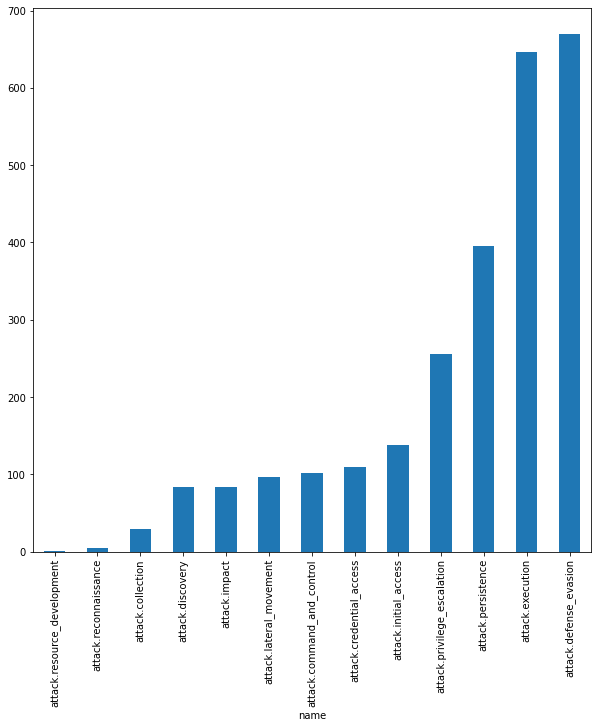

In [59]:
plot = s2.plot(kind='bar', figsize=(10, 10))

## Map our rules to the Mitre Navigator

link: https://mitre-attack.github.io/attack-navigator/

output file: navigator_data_export.json

Once the output file is created, visit the navigator page and select the "Open Existing Layer" option.

Our export is using the "score" field to hold the occurence information. This can be then used to highlight where we got better coverage. 
Click on the "Color Setup" and adjust the "High value" 
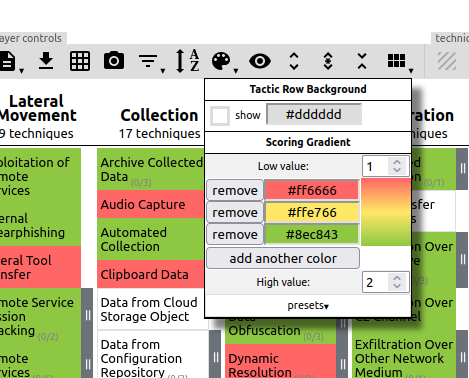


In [60]:
'''
Export to Mitre ATT&CK navigator

https://mitre-attack.github.io/attack-navigator/

select "Open Existing Layer" -> "Load a layer from your computer or a URL"

This code section will produce a json suitable for import
'''


navigator_json = {
    "name": "layer",
    "versions": {
        "attack": "9",
        "navigator": "4.3",
        "layer": "4.2"
    },
    "domain": "enterprise-attack",
    "description": "",
    "filters": {
        "platforms": [
            "Linux",
            "macOS",
            "Windows",
            "Azure AD",
            "Office 365",
            "SaaS",
            "IaaS",
            "Google Workspace",
            "PRE",
            "Network",
            "Containers"
        ]
    },
    "sorting": 0,
    "layout": {
        "layout": "side",
        "aggregateFunction": "average",
        "showID": False,
        "showName": True,
        "showAggregateScores": False,
        "countUnscored": False
    },
    "hideDisabled": False,
    "techniques": [],
    "gradient": {
        "colors": [
            "#ff6666",
            "#ffe766",
            "#8ec843"
        ],
        "minValue": 1,
        "maxValue": 2
    },
    "legendItems": [],
    "metadata": [],
    "showTacticRowBackground": False,
    "tacticRowBackground": "#dddddd",
    "selectTechniquesAcrossTactics": True,
    "selectSubtechniquesWithParent": False
}



# I need a function to search if a given Technique is present in the navigator json
def is_technique_present(t_number):
    for i in navigator_json['techniques']:
        if i['techniqueID'] == t_number:
            return True
    return False


#I also need a method that will increment score value for given technique
def increment_tech_score(t_number):
    for i in navigator_json['techniques']:
        if i['techniqueID'] == t_number:
            i['score']+=1

# create a dict of techniques where each of them will contain a list of tactics they are used in
# 
# technique_lookup = { 'T1053': ['execution', 'persistence', 'privilege_escalation'],
#                        ...
# }
technique_lookup = {}
        

for phase in mitre_attck:
    #print(phase)
    for tactic in mitre_attck[phase]:
        #print(f"\t{tactic}")
        for technique in mitre_attck[phase][tactic]:
            #print(f"\t\t{technique}")
            if isinstance(mitre_attck[phase][tactic][technique], dict):
                TQ_value = list(mitre_attck[phase][tactic][technique].keys())[0]
                #print(f"\t\t\t{TQ_value}")
            else:
                TQ_value = mitre_attck[phase][tactic][technique]
                #print(f"\t\t\t{mitre_attck[phase][tactic][technique]}")
            if TQ_value in technique_lookup:
                technique_lookup[TQ_value].add(phase)
            else:
                technique_lookup[TQ_value] = {phase}


# Rules usually hold the MITRE information in the tags meta field  (SOC Prime)
# tags =  "attack.t1036, attack.defense_evasion"
# or
# in mitre and scenario fields  (fishtech group)
# "mitre":"T1486","scenario":"impact"}
#
# or to make it more complicated Google Cloud security puts it into
# mitre_ids = "TA0005;T1036"\n'

# Examples:
#
# possible_unmanaged_powershell_detected_via_sysmon:T1086,T1055:['execution', 'defense evasion', 'privilege escalation']
# enumeration_and_proxy_bypass_by_trojan_banker:T1059,T1135,T1057,T1018,T1082,T1016:['execution', 'discovery', '']
# lucifer_banking_trojan_dropped_by_fedex_phishing_campaign:T1053,T1060,T1081,T1114,T1082:['privilege escalation', 'persistence', 'credential access', 'collection', 'discovery']
#

'''
example of navigator_json["techniques"] entry,the 'score' will hold the occurence value
if a technique is in more than one tactic, and the rule does not specify any details, we will increase the score value for all instances

{
"techniqueID": "T1021",
"tactic": "lateral-movement",
"score": 1,
"color": "",
"comment": "",
"enabled": true,
"metadata": [],
"showSubtechniques": false
}

'''



for item in rules_set['ruleJobLists']:
    rule_name = item['rule']['properties']['name']
    scenario = []
    techniques = []
    
    if  'mitre' in item['rule']['properties']['metadata']:
        # remove whitespace and do uppercase
        mitre = item['rule']['properties']['metadata']['mitre'].replace(" ", "").upper()
        tech = mitre.split(',')
        for i in tech:
            if re.match(r"(T\d{4})(\.?\d?\d?\d?)", i, re.IGNORECASE):
                techniques.append(i)
            elif re.match(r"attack.t\d{4}.*",i,  re.IGNORECASE):
                tech_rex = re.match(r"attack.(t\d{4}.*)",i, re.IGNORECASE)
                techniques.append(tech_rex.group(1))
        if 'scenario' in item['rule']['properties']['metadata']:
            if item['rule']['properties']['metadata']['scenario']:
                scenario = item['rule']['properties']['metadata']['scenario'].split(',')
    elif 'tags' in item['rule']['properties']['metadata']:
        tag_string = item['rule']['properties']['metadata']['tags'].replace(" ", "").upper()
        tags = tag_string.split(',')
        for i in tags:
            if re.match(r"(T\d{4})(\.?\d?\d?\d?)", i, re.IGNORECASE):
                techniques.append(i)
            elif re.match(r"attack.t\d{4}.*",i,  re.IGNORECASE):
                tech_rex = re.match(r"attack.(t\d{4}.*)",i, re.IGNORECASE)
                techniques.append(tech_rex.group(1))
    elif 'mitre_ids' in item['rule']['properties']['metadata']:
        # example mitre_ids = "TA0002;T1223"\n'
        mitre = item['rule']['properties']['metadata']['mitre_ids'].replace(" ", "").upper()
        if mitre.find(';'):
            tech = mitre.split(';')
        else:
            tech = mitre.split(',')
        for i in tech:
            if re.match(r"(T\d{4})(\.?\d?\d?\d?)", i, re.IGNORECASE):
                techniques.append(i)
            elif re.match(r"attack.t\d{4}.*",i,  re.IGNORECASE):
                tech_rex = re.match(r"attack.(t\d{4}.*)",i, re.IGNORECASE)
                techniques.append(tech_rex.group(1))

    for technique in techniques:
        tech_rex = re.match(r"(T\d{4})(\.?\d?\d?\d?)", technique, re.IGNORECASE)
        if tech_rex:
            if tech_rex.group(2):
                if tech_rex.group(1) in techniques:
                    # Remove redundant data about a technique used 
                    # if there is more specific information
                    # input T1547, T1547.001, T1547.002
                    # output T1547.001, T1547.002
                    #print(f"Removing: {tech_rex.group(1)}")
                    '''
                    Removing: T1547
                    ['T1106', 'T1547.001', 'T1112']
                    '''
                    techniques.remove(tech_rex.group(1))
            
    
    #add techniques to the json
    if techniques:
        #add to navigator_json['techniques']
        for technique in techniques:
            if is_technique_present(technique):
                # increment the score
                increment_tech_score(technique)
            else:
                #create technique entry in validator json
                # but first check if given technique is in my lookup since It could be something new
                if '.' in technique:
                    technique = technique.split(".")[0]
                if technique not in technique_lookup:
                    if technique == "T1064":
                        continue # T1064 Scripting technique is deprecated.
                    elif technique == "T1034":
                        continue # This is from ATT&CK 6.3 content transfered to hijack execution flow
                    else:
                        #print(f"technique:{technique} not found in lookup!")
                        continue
                else:
                    # since one technique could be in more than one tactic
                    # 'T1574': {'privilege_escalation', 'defense_evasion', 'persistence'},
                    
                    if len(technique_lookup[technique]) > 1:
                        for tactic in technique_lookup[technique]:
                            navigator_json['techniques'].append({
                                                            "techniqueID": technique,
                                                            "tactic": tactic.replace('_','-'), # I am using _ but navigator uses -
                                                            "score": 1,
                                                            "color": "",
                                                            "comment": "",
                                                            "enabled": True,
                                                            "metadata": [],
                                                            "showSubtechniques": False
                                                            })
                    else:
                        navigator_json['techniques'].append({
                                                            "techniqueID": technique,
                                                            "tactic": list(technique_lookup[technique])[0].replace('_','-'),
                                                            "score": 1,
                                                            "color": "",
                                                            "comment": "",
                                                            "enabled": True,
                                                            "metadata": [],
                                                            "showSubtechniques": False
                                                            })
        
        
        
    else:
        # TODO: check if every entry here does not contain mitre meta
        #print(f"There is no technique with rule: {rule_name}")
        continue
            

In [61]:
#pprint(navigator_json)
import json

with open('navigator_data_export.json', 'w') as fp:
    json.dump(navigator_json, fp)